<br/>

## <div style="padding:10px;background-color:#9d5a47;margin:10;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 1px 10px;overflow:hidden;font-weight:50;width:auto">Sony Churn Project - Modeling</div>

## Model Type: Binary Classification

## Null Hypothesis: No Churn

## Choosing metrics:

**Assuming that the primary purpose of this analysis is to mitigate churn or to retain business:**
* Generating false positives (churn = true) would be an acceptable risk as any additional marketing/retention measures directed at those customers would not hurt the business.
  * There is a caveat if those measure cost significant dollars to the company. For instance, offering the customer a special deal on their subscription.
* Generating false negatives (churn = false) presents a challenge because those customers about to leave would not be addressed.
  * We should add a cost-sensitive weighting to punish creating false negatives.

<br>

* Given the above, we can focus on recall as an important metric for this model.  Of course, we will take into account F1 and accuracy as well.

In [1]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np
np.random.seed(42)
rng = np.random.default_rng(42)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'png'

from pathlib import Path
data_path = Path('./data')

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

import shap

In [2]:
df = pd.read_parquet(data_path / "Data_Science_Challenge - prepped.parquet")
df.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total eve minutes,total night minutes,total intl minutes,customer service calls,churn,minutes per day call,minutes per eve call,minutes per night call,minutes per intl call
0,128,415,False,True,25,265.1,197.4,244.7,10.0,1,False,2.410000,1.993939,2.689011,3.333333
1,107,415,False,True,26,161.6,195.5,254.4,13.7,1,False,1.313821,1.898058,2.469903,4.566667
2,137,415,False,False,0,243.4,121.2,162.6,12.2,0,False,2.135088,1.101818,1.563462,2.440000
3,84,408,True,False,0,299.4,61.9,196.9,6.6,2,False,4.216901,0.703409,2.212360,0.942857
4,75,415,True,False,0,166.7,148.3,186.9,10.1,3,False,1.475221,1.215574,1.544628,3.366667


## First modeling pass - no balance correction

In [3]:
# train test split
X = df.drop(columns=["churn"])
y = df["churn"]

train_ds = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_ds

In [4]:
for x in train_ds:
    print(x.shape)


(2666, 14)
(667, 14)
(2666,)
(667,)


20% test creates a decent shape - enough samples in the test set to see if we're good and enough in the train set to let many models learn

We have created a train set and a validation set.  I would ideally also create a holdout set, but the number of samples is already low.  In a real dataset of this type, there would be vastly more samples.


### Random Forest Classification - imbalanced

Decent accuracy but low recall is probably due to class imbalance and emphasises the difficulty of this particular model: creating false negatives


              precision    recall  f1-score   support

       False       0.93      0.99      0.96       570
        True       0.89      0.57      0.69        97

    accuracy                           0.93       667
   macro avg       0.91      0.78      0.83       667
weighted avg       0.92      0.93      0.92       667



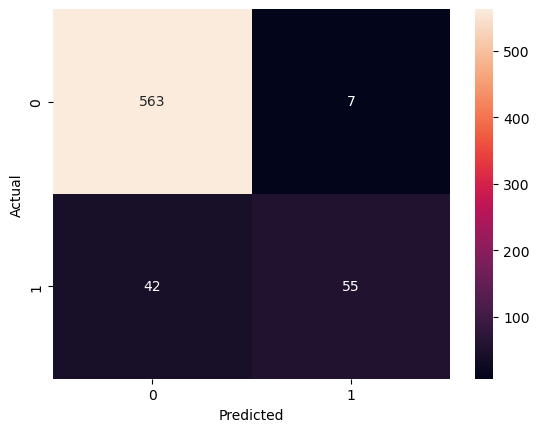

In [5]:
rfc = RandomForestClassifier(
    n_estimators=45, criterion="entropy", n_jobs=-1
).fit(X_train, y_train)

y_pred = rfc.predict(X_test)

confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.ylabel("Actual")
plt.xlabel("Predicted")

print(classification_report(y_test, y_pred))

## Logistic Regression Model - imbalanced

LR is much more prone to balance effects. Also multi-collinearity. 


              precision    recall  f1-score   support

       False       0.88      0.96      0.92       570
        True       0.51      0.22      0.30        97

    accuracy                           0.86       667
   macro avg       0.70      0.59      0.61       667
weighted avg       0.83      0.86      0.83       667



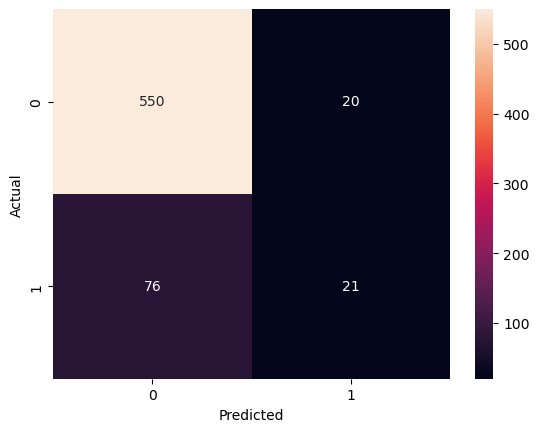

In [6]:
# logistic regression

# use StandardScaler to scale the data for linear model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = lr.predict(X_test)

confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.ylabel("Actual")
plt.xlabel("Predicted")

print(classification_report(y_test, y_pred))

## Rebalance the data

We choose not to use undersampling due to the lack of original samples.

We may choose a model like SMOTE or we can oversample.


In [7]:
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

balanced_ds = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)
X_train, X_test, y_train, y_test = balanced_ds

for x in balanced_ds:
    print(x.shape)

(4560, 14)
(1140, 14)
(4560,)
(1140,)


In [8]:
# check balance
y_train.value_counts()


True     2280
False    2280
Name: churn, dtype: int64


### Random Forest Classification - Balanced


              precision    recall  f1-score   support

       False       0.95      0.93      0.94       570
        True       0.93      0.95      0.94       570

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



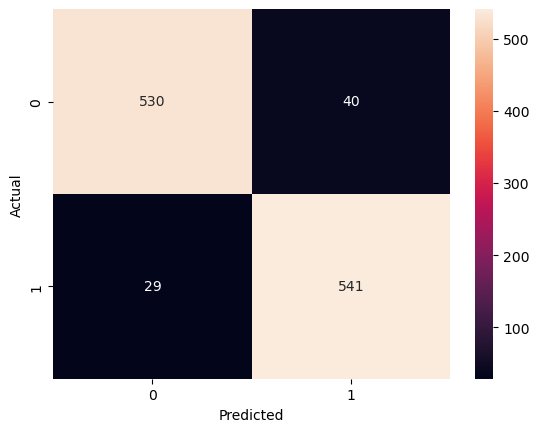

In [9]:
rfc = RandomForestClassifier(
    n_estimators=45, criterion="entropy", n_jobs=-1
).fit(X_train, y_train)

y_pred = rfc.predict(X_test)

confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.ylabel("Actual")
plt.xlabel("Predicted")

print(classification_report(y_test, y_pred))

## Logistic Regression Model - balanced with SMOTE

We should be aware that because we used SMOTE, the model will significantly improve recall - the synthetic "True" data could be artificially easier to predict.



              precision    recall  f1-score   support

       False       0.80      0.78      0.79       570
        True       0.78      0.81      0.80       570

    accuracy                           0.79      1140
   macro avg       0.79      0.79      0.79      1140
weighted avg       0.79      0.79      0.79      1140



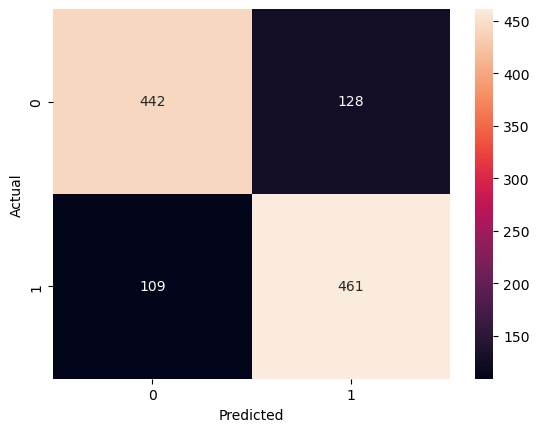

In [10]:
# scale for linear model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)
y_pred = lr.predict(X_test)

confusion_matrix(y_test, y_pred)
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.ylabel("Actual")
plt.xlabel("Predicted")

print(classification_report(y_test, y_pred))

## Tune RFC - balanced

The data is very small.  We'll use a brute force technique (grid search)

In [11]:
# grid search for good hyperparameters

rfc = RandomForestClassifier()

param_grid = {
    "n_estimators": [45, 55, 80, 150],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 20, 50],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["auto", "sqrt", "log2"],
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 80}

In [12]:
grid_search.score(X_test, y_test)


0.9412280701754386

              precision    recall  f1-score   support

       False       0.94      0.93      0.93       570
        True       0.93      0.94      0.94       570

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



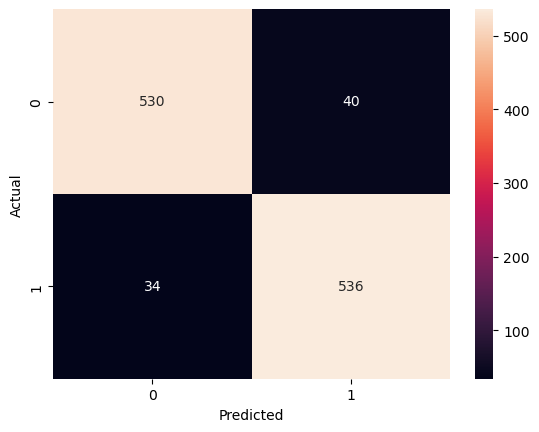

In [13]:
rfc = grid_search.best_estimator_

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# plot confusion matrix
confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.ylabel("Actual")
plt.xlabel("Predicted")

print(classification_report(y_test, y_pred))

In [14]:
# best feature importances
feature_importances = pd.DataFrame(
    rfc.feature_importances_, index=X.columns, columns=["importance"]
).sort_values("importance", ascending=False)

feature_importances

,importance
total day minutes,0.182743
international plan,0.138789
customer service calls,0.102221
total eve minutes,0.077448
minutes per day call,0.076763
minutes per intl call,0.066758
minutes per eve call,0.056465
total night minutes,0.055862
area code,0.050318
total intl minutes,0.050146


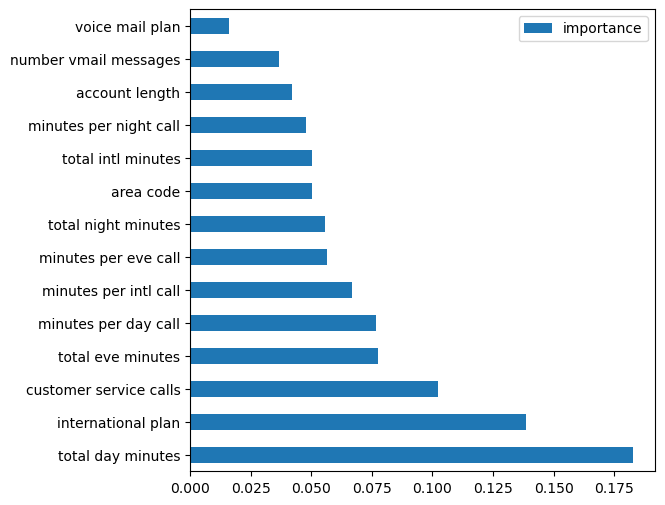

In [15]:
feature_importances.plot(kind="barh", figsize=(6, 6))

In [16]:
# perform shapley analysis on the rfc model

explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_train)

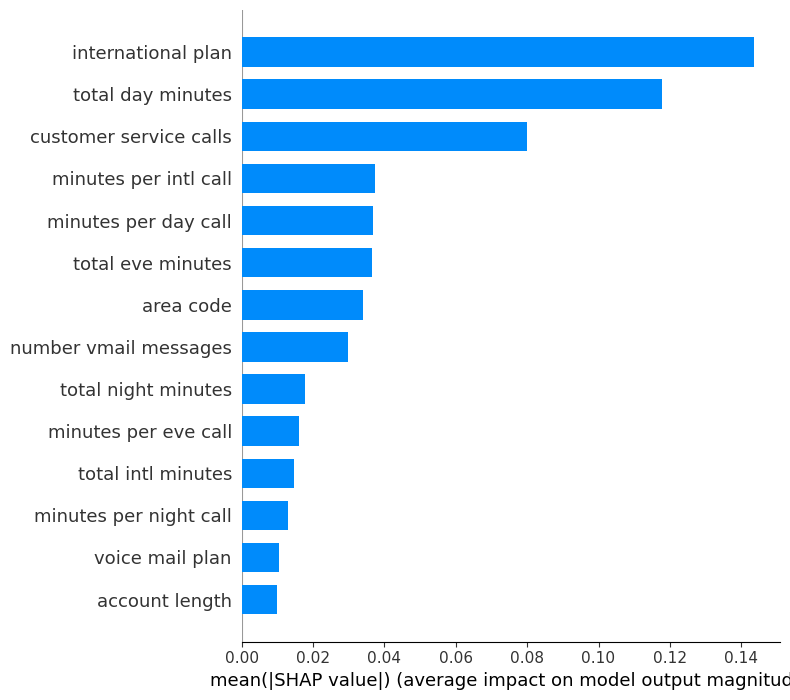

In [17]:
# summary plot with column names
shap.summary_plot(
    shap_values[1], X_train, plot_type="bar", feature_names=X.columns
)

# Feature Importance Analysis

* It looks like the number of minutes one uses the plan is significant here, accounting for 4 out of the top 6 feature importances
* Other standouts are the International plan and the number of Customer Service Calls

<br><br>

## Possible issues after deployment

   **Data Drift** - when the data distribution changes.  Either there's been a data engineering problem or the incoming data has changed signficantly for some external reason
   Fix with: 
   * addressing the data engineering
   * or by adding more data to address the major change
   
   **Concept Drift** - this happens when the relationship between the input and output variables have changed over time.
   * Fix with:
   * retraining the model on the new data.  This may need to be done continuously.

Both these drift types should be monitored